## Data Enhancement and Augmentation Techniques for Oculomotoric Biometric Identification using DeepEye

In [1]:
import os
import socket

%pylab inline
%load_ext autoreload
%autoreload 2
print(socket.gethostname())

Populating the interactive namespace from numpy and matplotlib
ift-dgx


In [2]:
import joblib
import numpy as np
import random
from Evaluation import evaluation
import sys
import seaborn as sns
from tqdm.notebook import tqdm

## Set up the GPU you want to train on
* if you want to train on Google-Colab or the CPU you don't need to specify the GPU

In [3]:
flag_train_on_gpu = True
GPU = 1
if flag_train_on_gpu:
    import tensorflow as tf
    # select graphic card
    os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    config = tf.compat.v1.ConfigProto(log_device_placement=True)
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    tf_session = tf.compat.v1.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0



## Load the data and the parameter for the model

In [4]:
Y_columns = {'subId': 0,
 'session': 1,
 'trialId': 2,
 'seqId': 3,
 'original_trial_length_before_padding': 4}

train_data = np.load('Data/train_data.npz')
test_data = np.load('Data/test_data.npz')
X_train = train_data['X_train']
Y_train = train_data['Y_train']
X_test = test_data['X_test']
Y_test = test_data['Y_test']

### Show example instances of the data

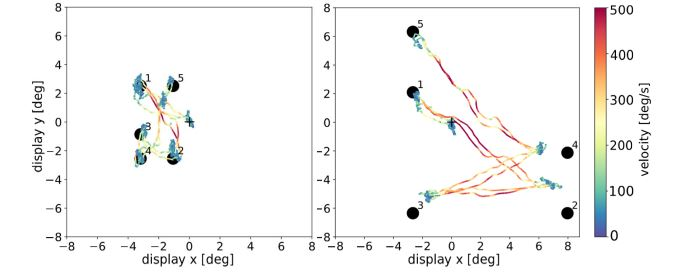

In [1]:
from IPython.display import Image
Image(filename='images/scanpaths.jpg')

## Apply the Data Augmentation/Enhancement
* Here you should implement your own data augmentation/enhancement
* implement the function 'transform(X_train,Y_train,Y_columns)' in 'DataAugmentation/data_augmentation.py'

In [5]:
from DataAugmentation import data_augmentation
X_train_augmented,Y_train_augmented = data_augmentation.transform(X_train,Y_train,Y_columns)

## Train model and get embeddings

In [6]:
embeddings_concatenated_augmented = evaluation.evaluate_create_test_embeddings(X_train_augmented,Y_train_augmented,X_test,Y_test,Y_columns)

/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fast_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_velocity_diff_input (Input [(None, 1000, 2)]    0                                            
__________________________________________________________________________________________________
fast_transform (TransformationL (None, 1000, 4)      0           fast_input[0][0]                 
____________________________________________________________________________________________

14/14 [==============================] - 5s 60ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/100
14/14 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/100
14/14 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
14/14 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
14/14 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_lo

In [7]:
embeddings_concatenated_baseline = evaluation.evaluate_create_test_embeddings(X_train,Y_train,X_test,Y_test,Y_columns)

/usr/local/apps/Anaconda3/2020.11/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fast_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_input (InputLayer)         [(None, 1000, 4)]    0                                            
__________________________________________________________________________________________________
slow_velocity_diff_input (Input [(None, 1000, 2)]    0                                            
__________________________________________________________________________________________________
fast_transform (TransformationL (None, 1000, 4)      0           fast_input[0][0]                 
____________________________________________________________________________________________

Epoch 1/100
1688/1688 [==============================] - 30s 17ms/step - loss: 3.0391 - accuracy: 0.2048 - val_loss: 2.6283 - val_accuracy: 0.3133
Epoch 2/100
1688/1688 [==============================] - 28s 17ms/step - loss: 1.6358 - accuracy: 0.5277 - val_loss: 1.2844 - val_accuracy: 0.6190
Epoch 3/100
1688/1688 [==============================] - 27s 16ms/step - loss: 1.0697 - accuracy: 0.6811 - val_loss: 0.9925 - val_accuracy: 0.7018
Epoch 4/100
1688/1688 [==============================] - 28s 17ms/step - loss: 0.8402 - accuracy: 0.7472 - val_loss: 0.8087 - val_accuracy: 0.7552
Epoch 5/100
1688/1688 [==============================] - 28s 16ms/step - loss: 0.6959 - accuracy: 0.7878 - val_loss: 0.7250 - val_accuracy: 0.7824
Epoch 6/100
1688/1688 [==============================] - 27s 16ms/step - loss: 0.5829 - accuracy: 0.8203 - val_loss: 0.7062 - val_accuracy: 0.7904
Epoch 7/100
1688/1688 [==============================] - 27s 16ms/step - loss: 0.5012 - accuracy: 0.8438 - val_loss: 0

## Plot results

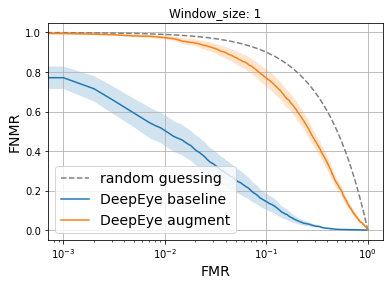

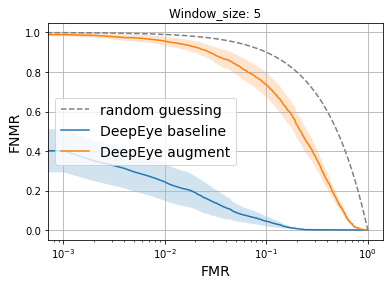

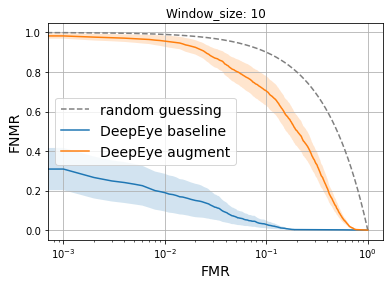

In [8]:
window_sizes = [1,5,10]
n_train_users = 0
n_enrolled_users = 1
n_impostors = 24
n_enrollment_sessions = 3
n_test_sessions = 1
test_user = None
test_sessions = None
user_test_sessions = None 
enrollment_sessions = None
verbose = 0
random_state = 42,
seconds_per_session = None
model_names = ['DeepEye baseline',
              'DeepEye augment']
embedding_list = [embeddings_concatenated_baseline,embeddings_concatenated_augmented]
metric_lists = []
for i in range(len(model_names)):
    metric_dict = dict()
    for random_state in tqdm(np.arange(10)):
        from sklearn import metrics
        (score_dicts, label_dicts) = evaluation.get_scores_and_labels_from_raw(
                                    test_embeddings=embedding_list[i],
                                    Y_test=Y_test,
                                    Y_columns=Y_columns,
                                    window_sizes=window_sizes,
                                    n_train_users = n_train_users,
                                    n_enrolled_users = n_enrolled_users,
                                    n_impostors = n_impostors,
                                    n_enrollment_sessions = n_enrollment_sessions,
                                    n_test_sessions = n_test_sessions,
                                    test_user = test_user,
                                    test_sessions = test_sessions,
                                    user_test_sessions = user_test_sessions,
                                    enrollment_sessions = enrollment_sessions,
                                    verbose = verbose,
                                    random_state = random_state,
                                    seconds_per_session = seconds_per_session)

        for window_size in window_sizes:
            window_size = str(window_size)
            cur_scores = score_dicts[window_size]
            cur_label  = label_dicts[window_size]
            fpr, tpr, thresholds = metrics.roc_curve(cur_label, cur_scores, pos_label=1)
            if window_size not in metric_dict:
                metric_dict[window_size] = dict()
            if 'fpr' not in  metric_dict[window_size]:
                metric_dict[window_size]['fpr'] = []
                metric_dict[window_size]['tpr'] = []
            metric_dict[window_size]['fpr'].append(fpr)
            metric_dict[window_size]['tpr'].append(tpr)
    metric_lists.append(metric_dict)


for window_size in window_sizes:
    for i in range(len(model_names)):
        metric_dict = metric_lists[i]
        model_name = model_names[i]
        if i == 0:
            plot_random = True
        else:
            plot_random = False
        window_size = str(window_size)
        evaluation.avg_fnr_fpr_curve(metric_dict[window_size]['fpr'], metric_dict[window_size]['tpr'], 
                label = model_name, plot_random=plot_random,
                title = 'Window_size: ' + window_size, plot_statistics = False,
                loc = 'best', plot_legend = True,
                plot_points = 1000, ncol=1,
                bbox_to_anchor=None,
                starting_point = None,
                fontsize = 14, xscale = 'log',
                setting = 'verification')
    plt.show()

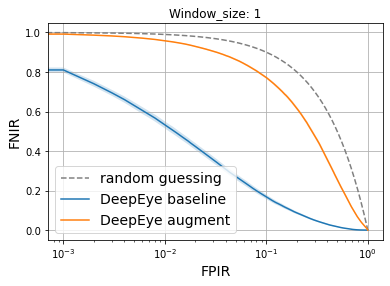

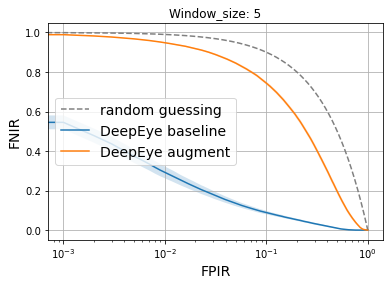

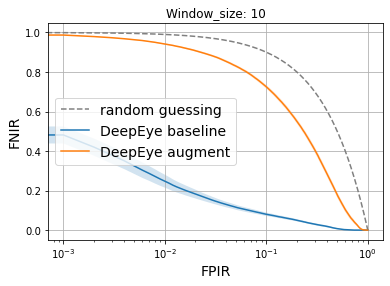

In [9]:
window_sizes = [1,5,10]
n_train_users = 0
n_enrolled_users = 20
n_impostors = 5
n_enrollment_sessions = 3
n_test_sessions = 1
test_user = None
test_sessions = None
user_test_sessions = None 
enrollment_sessions = None
verbose = 0
random_state = 42,
seconds_per_session = None
model_names = ['DeepEye baseline',
              'DeepEye augment']
embedding_list = [embeddings_concatenated_baseline,embeddings_concatenated_augmented]
metric_lists = []
for i in range(len(model_names)):
    metric_dict = dict()
    for random_state in tqdm(np.arange(10)):
        from sklearn import metrics
        (score_dicts, label_dicts) = evaluation.get_scores_and_labels_from_raw(
                                    test_embeddings=embedding_list[i],
                                    Y_test=Y_test,
                                    Y_columns=Y_columns,
                                    window_sizes=window_sizes,
                                    n_train_users = n_train_users,
                                    n_enrolled_users = n_enrolled_users,
                                    n_impostors = n_impostors,
                                    n_enrollment_sessions = n_enrollment_sessions,
                                    n_test_sessions = n_test_sessions,
                                    test_user = test_user,
                                    test_sessions = test_sessions,
                                    user_test_sessions = user_test_sessions,
                                    enrollment_sessions = enrollment_sessions,
                                    verbose = verbose,
                                    random_state = random_state,
                                    seconds_per_session = seconds_per_session)

        for window_size in window_sizes:
            window_size = str(window_size)
            cur_scores = score_dicts[window_size]
            cur_label  = label_dicts[window_size]
            fpr, tpr, thresholds = metrics.roc_curve(cur_label, cur_scores, pos_label=1)
            if window_size not in metric_dict:
                metric_dict[window_size] = dict()
            if 'fpr' not in  metric_dict[window_size]:
                metric_dict[window_size]['fpr'] = []
                metric_dict[window_size]['tpr'] = []
            metric_dict[window_size]['fpr'].append(fpr)
            metric_dict[window_size]['tpr'].append(tpr)
    metric_lists.append(metric_dict)


for window_size in window_sizes:
    for i in range(len(model_names)):
        metric_dict = metric_lists[i]
        model_name = model_names[i]
        if i == 0:
            plot_random = True
        else:
            plot_random = False
        window_size = str(window_size)
        evaluation.avg_fnr_fpr_curve(metric_dict[window_size]['fpr'], metric_dict[window_size]['tpr'], 
                label = model_name, plot_random=plot_random,
                title = 'Window_size: ' + window_size, plot_statistics = False,
                loc = 'best', plot_legend = True,
                plot_points = 1000, ncol=1,
                bbox_to_anchor=None,
                starting_point = None,
                fontsize = 14, xscale = 'log',
                setting = 'identification')
    plt.show()